## CRAG(Corrective Retrieval Augmented Generation)

CRAG는 RAG의 개선된 버전입니다. **RAG의 한계를 보완**하기 위해 개발된 기술로, 검색된 문서의 품질을 평가하고 필요시 수정하는 메커니즘을 추가했습니다.

### 주요 특징

**1. 검색 평가자(Retrieval Evaluator)**
- 검색된 문서의 관련성과 품질을 평가
- 문서가 충분히 정확하고 관련성이 있는지 판단

**2. 수정 메커니즘**
- 검색 결과가 부정확하거나 불충분할 경우 대응
- 추가 검색, 웹 검색, 또는 지식 정제 수행

**3. 동적 처리 방식**
검색 품질에 따라 세 가지 경로로 분기:
- **Correct**: 검색 결과가 좋을 경우 → 그대로 사용
- **Incorrect**: 검색 결과가 나쁠 경우 → 웹 검색 등 추가 소스 활용
- **Ambiguous**: 애매한 경우 → 지식 정제 후 사용

### RAG와의 차이점

- **RAG**: 검색된 문서를 무조건 신뢰하고 사용
- **CRAG**: 검색 품질을 평가하고, 필요시 보완하거나 다른 소스 활용

이를 통해 더 정확하고 신뢰할 수 있는 답변 생성이 가능합니다.

- 참고 자료: https://wikidocs.net/270686
- 관련 논문: https://arxiv.org/pdf/2401.15884

## 환경 변수

In [ ]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 문서 다운로드

In [8]:
import os
import urllib.request


def download_file(url, dir="./temp"):
    if not os.path.exists(dir):
        os.makedirs(dir)

    file_path = os.path.join(dir, "doc.pdf")
    urllib.request.urlretrieve(url, file_path)

    file_size = os.path.getsize(file_path)
    print(f"다운로드 완료! 파일 크기: {file_size:,}", "bytes")

    return file_path

In [9]:
# "소프트웨어정책연구소(SPRi) - 2025년 10월호" PDF를 다운로드합니다.
downloaded_path = download_file("https://spri.kr/download/23735")
downloaded_path

다운로드 완료! 파일 크기: 1,207,479 bytes


'./temp/doc.pdf'

## 문서 로더

In [10]:
from langchain_community.document_loaders import PyPDFLoader

documents = PyPDFLoader(downloaded_path).load()
print(f"총 {len(documents)} 페이지 로드됨")

총 29 페이지 로드됨


## 문서 분할

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
splits = text_splitter.split_documents(documents)
print(f"총 {len(splits)}개의 청크로 분할됨")

총 70개의 청크로 분할됨


## 문서 임베딩

In [12]:
from langchain.storage import LocalFileStore
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.vectorstores import FAISS


# 임베딩 모델 생성
underlying_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


embeddings = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings,
    document_embedding_cache=LocalFileStore("./cache"),
    namespace=underlying_embeddings.model,
    query_embedding_cache=True,
)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = FAISS.from_documents(splits, embeddings)


/Users/anpigon/Workspace/Wantedlab/langchain-academy/venv/lib/python3.12/site-packages/langchain/embeddings/cache.py:58: UserWarning: Using default key encoder: SHA-1 is *not* collision-resistant. While acceptable for most cache scenarios, a motivated attacker can craft two different payloads that map to the same cache key. If that risk matters in your environment, supply a stronger encoder (e.g. SHA-256 or BLAKE2) via the `key_encoder` argument. If you change the key encoder, consider also creating a new cache, to avoid (the potential for) collisions with existing keys.
  _warn_about_sha1_encoder()


## 리트리버 생성

In [13]:
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5, "fetch_k": 50},
)

In [14]:
retriever.invoke("미국 캘리포니아주 의회가 발의한 법안은?")

[Document(id='625c5d38-8e8f-49b7-9ab2-53cf8cf54534', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 6, 'page_label': '7'}, page_content='정책･법제기업･산업기술･연구인력･교육\n5\n미국 캘리포니아주 의회, 미국 최초로 미성년자 보호를 위한 AI 챗봇 규제 통과n미국 캘리포니아주 의회가 미국 최초로 미성년자와 취약 사용자 보호를 위해 AI 동반자 챗봇을 규제하는 SB-243 법안을 통과시켰으며, 주지사 서명 시 2026년 1월 1일부터 발효 예정n동 법안은 동반자 챗봇 운영 플랫폼을 대상으로 사용자의 자살이나 자해를 방지하기 위한 프로토콜 수립 및 미성년자 보호 조치를 요구하고, 위법으로 인한 피해자에게 민사소송 권리를 부여\nKEY Contents'),
 Document(id='5fc0f45e-99cd-4944-a171-e9a7add59965', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 9, 'page_label': '10'}, page_content='<‘제미나이 2.

## 상태

In [16]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document


class State(TypedDict):
    question: Annotated[str, "사용자 질문"]
    generation: Annotated[str, "LLM에서 생성된 답변"]
    web_search: Annotated[str, "웹검색 필요 여부"]
    documents: Annotated[list[Document], "검색된 문서들"]

## 문서 검색 노드

In [17]:
def retrieve_node(state: State):
    question = state.get("question")
    documents = retriever.invoke(question)
    return {"documents": documents}

In [20]:
results = retrieve_node({"question": "구글이 공개한 이미지 편집 모델 이름은?"})
results

{'documents': [Document(id='7625e4ff-c11a-4443-b3e5-384bfc6a1814', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 9, 'page_label': '10'}, page_content='SPRi AI Brief2025년 10월호\n8\n구글, 이미지 편집 모델 ‘제미나이 2.5 플래시 이미지’ 공개n‘나노 바나나’라는 가칭으로 LMArena에서 1위를 차지했던 ‘제미나이 2.5 플래시 이미지’가 제미나이 앱의 이미지 편집 기능에 정식으로 채택 n제미나이 2.5 플래시 이미지는 사람이나 동물과 같은 캐릭터의 일관성에서 뛰어난 품질을 발휘하여, 배경이나 설정을 바꾸거나 여러 장의 사진을 합성해도 동일한 형상을 유지\nKEY Contents\n£ ‘나노 바나나’로 사전 공개된 ‘제미나이 2.5 플래시 이미지’, 제미나이 앱에 추가n구글이 제미나이 앱에 새로운 이미지 생성·편집 모델 ‘제미나이 2.5 플래시 이미지(Gemini 2.5 Flash Image)’ 기반의 이미지 편집 기능을 추가 ∙이 모델은 LMArena*에서 ‘나노 바나나(Nano Banana)’라는 가칭으로 공개되어 뛰어난 성능으로 1위를 차지하며 화제를 모았으며, 이번 업데이트로 제미나이 앱에 통합* 인간 선호도를 기반으로 AI 모델을 비교 평가하는 웹 기반 플랫폼∙이번 업데이트는 전 세계 유·무료 사용자에게 모두 제공되며, 제미나이 앱에서 생성되거나 편집된 모든 이미지에는 육안으로 식별되지 않는 워터마크가 포함되어 AI 생성 사실을 확인 가능n

## 답변 생성 노드

In [21]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)


def generate_node(state: State):
    question = state.get("question")
    documents = state.get("documents")
    system_prompt = """당신은 질문-답변(Question-Answering)을 수행하는 친절한 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
한글로 답변해 주세요. 단, 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요."""
    prompt_template = "#Question: {question}\n\n #Context: {context}\n\n #Answer:"

    response = llm.invoke(
        [
            ("system", system_prompt),
            (
                "user",
                prompt_template.format(
                    question=question,
                    context=documents,
                ),
            ),
        ]
    )
    return {"generation": response.content}

In [22]:
generate_node({**results, "question": "구글이 공개한 이미지 편집 모델 이름은?"})

{'generation': '구글이 공개한 이미지 편집 모델 이름은 ‘제미나이 2.5 플래시 이미지(Gemini 2.5 Flash Image)’입니다.'}

## 관련성 평가 노드

In [23]:
from pydantic import BaseModel, Field


class GradeDocuments(BaseModel):
    """검색된 문서의 관련성을 판단하기 위한 binary score"""

    binary_score: str = Field(
        ...,
        description="검색된 문서가 사용자 질문과 얼마나 관련성이 있는지 평가하는 평가자입니다.\n"
        "문서에 질문과 관련된 키워드나 의미론적 내용이 포함되어 있다면, 관련성이 있다고 평가하세요.\n"
        "문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 응답하세요",
    )


def grade_documents_node(state: State):
    question = state.get("question")
    documents = state.get("documents")

    prompt_template = (
        "Retrieved document: \n\n {document} \n\n User question: {question}"
    )
    llm_with_structured_output = llm.with_structured_output(GradeDocuments)

    filtered_docs: list[Document] = []
    for doc in documents:
        response = llm_with_structured_output.invoke(
            prompt_template.format(
                question=question,
                document=doc,
            )
        )
        if response.binary_score == "yes":
            filtered_docs.append(doc)

    return {
        "documents": filtered_docs,
        "web_search": "yes" if len(filtered_docs) == 0 else "no",
    }

## 쿼리 재작성 노드

In [26]:
def query_rewrite_node(state: State):
    question = state.get("question")
    system_prompt = "당신은 질문 재작성 도구입니다.\n"
    "제공된 질문을 웹 검색에 최적화된 더 좋은 질문으로 개선합니다.\n"
    "기존 질문을 살펴보고 의미적 의도/의미를 추론해 보세요.\n"
    "재작성된 질문만 반환하세요."
    prompt_template = "기존 질문: {question}"
    response = llm.invoke(
        [
            ("system", system_prompt),
            (
                "user",
                prompt_template.format(question=question),
            ),
        ]
    )
    return {"question": response.content}

In [27]:
query_rewrite_node({"question": "구글이 만든 이미지 생성형 AI 모델은?"})

{'question': '구글이 개발한 이미지 생성 AI 모델에는 어떤 것들이 있나요?'}

## 웹 검색 노드

In [39]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=3)


def web_search_node(state: State):
    question = state.get("question")
    documents = state.get("documents", [])

    results = web_search_tool.invoke({"query": question})
    for r in results["results"]:
        documents.append(
            Document(page_content=r["content"], metadata={"url": r["url"]})
        )

    return {"documents": documents}


In [40]:
web_search_node(
    {"question": "구글이 개발한 이미지 생성 AI 모델에는 어떤 것들이 있나요?"}
)

{'documents': [Document(metadata={'url': 'https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview?hl=ko'}, page_content='Vertex AI 기반 Imagen은 Google의 최첨단 이미지 생성형 AI 특성을 애플리케이션 개발자에게 제공합니다. Vertex AI 기반 Imagen을 사용하면 애플리케이션 개발자는'),
  Document(metadata={'url': 'https://marcus-story.tistory.com/65'}, page_content='Imagen-3는 Google DeepMind가 개발한 고급 텍스트-이미지 변환(T2I) 모델입니다. 이 모델은 텍스트 프롬프트로부터 고품질 이미지를 생성하는 잠재 확산'),
  Document(metadata={'url': 'https://fundmeter.tistory.com/entry/%EA%B5%AC%EA%B8%80-AI-%EB%AA%A8%EB%8D%B8-%EC%A2%85%EB%A5%98-%EA%B0%81-%EB%AA%A8%EB%8D%B8%EB%B3%84-%ED%8A%B9%EC%A7%95-%EB%B9%84%EA%B5%90-%EB%B6%84%EC%84%9D'}, page_content='CodeGemma는 코딩 작업을 지원하며, PaliGemma는 이미지 및 비디오 관련 작업에 유용합니다. ## 그 외 다양한 Google AI 모델 Google은 Gemini와 Gemma')]}

## 그래프 작성

In [41]:
from typing import Literal
from langgraph.graph import StateGraph


def decide_to_generate(state: State) -> Literal["query_rewrite", "generate"]:
    if state.get("web_search") == "yes":
        return "query_rewrite"
    else:
        return "generate"


builder = StateGraph(State)
builder.add_node(retrieve_node)
builder.add_node(grade_documents_node)
builder.add_node(generate_node)
builder.add_node(query_rewrite_node)
builder.add_node(web_search_node)

builder.add_edge(retrieve_node.__name__, grade_documents_node.__name__)
builder.add_conditional_edges(
    grade_documents_node.__name__,
    decide_to_generate,
    {
        "query_rewrite": query_rewrite_node.__name__,
        "generate": generate_node.__name__,
    },
)
builder.add_edge(query_rewrite_node.__name__, web_search_node.__name__)
builder.add_edge(web_search_node.__name__, generate_node.__name__)

builder.set_entry_point(retrieve_node.__name__)
builder.set_finish_point(generate_node.__name__)

graph = builder.compile()

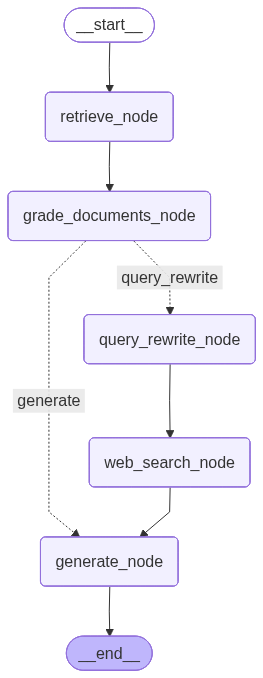

In [42]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## 그래프 실행

In [45]:
for event in graph.stream(
    {"question": "세일즈포스가 개발한 LLM 성능 평가 지표는?"},
    stream_mode="updates",
):
    for key, value in event.items():
        print(f"\n===== {key.upper()} =====")
        print(value)



===== RETRIEVE_NODE =====
{'documents': [Document(id='682ab2c6-1c69-4aa8-90a0-13499b499fa5', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 18, 'page_label': '19'}, page_content='정책･법제기업･산업기술･연구인력･교육\n17\n세일즈포스, 실제 사용 환경에서 LLM 성능 검증을 위한 벤치마크 개발n세일즈포스가 실제 MCP 서버 기반의 다양한 작업을 통해 실제 사용 환경의 복잡성을 반영해 LLM의 성능을 평가할 수 있는 ‘MCP-Universe’ 벤치마크를 개발nMCP-Universe로 첨단 폐쇄형 및 개방형 AI 모델을 평가한 결과, 최고 점수를 기록한 GPT-5의 작업 성공률도 43.72%에 그쳐 MCP 기반 복잡한 작업 해결에 한계를 노출\nKEY Contents'), Document(id='45538ebc-e16f-4dc7-9118-b9cdc5c7b54f', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 23, 'page_label': '

In [46]:
for event in graph.stream(
    {"question": "LG AI Research 팀에서 개발한 AI 모델 이름은?"},
    stream_mode="updates",
):
    for key, value in event.items():
        print(f"\n===== {key.upper()} =====")
        print(value)



===== RETRIEVE_NODE =====
{'documents': [Document(id='e6a247a0-91c3-4197-94e3-383cf7deaac1', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'page': 20, 'page_label': '21'}, page_content='정책･법제기업･산업기술･연구인력･교육\n19\nMBZUAI와 G42, 추론 AI 모델 ‘K2 Think’ 오픈소스 공개nUAE의 모하메드 빈 자이드 AI 대학(MBZUAI)과 국영 AI 기업 G42가 혁신적인 사후 학습 기법과 테스트-타임 스케일링을 적용한 매개변수 320억 개의 추론 AI 모델 ‘K2 Think’를 공개nK2 Think는 수학 벤치마크에서 딥시크 V3.1과 오픈AI의 gpt-oss 120B와 같은 훨씬 더 큰 규모의 모델과 비슷한 성능을 기록했으며, 코딩 벤치마크에서는 딥시크 R1을 능가\nKEY Contents'), Document(id='7625e4ff-c11a-4443-b3e5-384bfc6a1814', metadata={'producer': 'Hancom PDF 1.3.0.505', 'creator': 'Hancom PDF 1.3.0.505', 'creationdate': '2025-10-02T12:57:42+09:00', 'author': 'dj', 'moddate': '2025-10-02T12:57:42+09:00', 'pdfversion': '1.4', 'source': './temp/doc.pdf', 'total_pages': 29, 'pag